<a href="https://colab.research.google.com/github/Erickrus/leetcode/blob/master/MCTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MONTE CARLO TREE SEARCH (MCTS)

In [ ]:
#@title Define Mermaid Ink
#https://github.com/jihchi/mermaid.ink

import base64
import io
import os
import requests
import IPython


from IPython.display import display
from PIL import Image

def mermaid(graph):
  mermaidInkUrl = 'https://mermaid.ink/img/'
  b = requests.get(
      mermaidInkUrl +
      base64.b64encode(
        graph.encode('ascii')
      ).decode("ascii")
    ).content

  with open("mermaid.png", "wb") as f:
    f.write(b)

  display(Image.open("mermaid.png"))
  os.remove("mermaid.png")


This implementation is based on John Levine's tutorial on youtube: https://www.youtube.com/watch?v=UXW2yZndl7U


Monte Carlo Tree Search

Monte Carlo Tree Search works in 4 phases

1. Tree traversal
 - UCB1 - Upper Confidence Bound 1 applied to trees

 - $UCB1(S_i) = \bar{V_i} + C \cdot \sqrt{\frac{ln{N}}{n_i}}$
 - Exploitation term $\bar{V_i}$
 - Exploration term $\sqrt{\frac{ln{N}}{n_i}}$
 - Exploration parameter: in the below example $C=2$


2. Node expansion
 - where you add extra nodes into the tree

3. Rollout (random simulation)
 - where you do a **random simulation** or work on the problem you are solving in order to find the **value**

4. Backpropagation
 - take the **value** found in the rollout, put that into a proper place in the tree backtrace upward from the node, level by level, up to the root node.



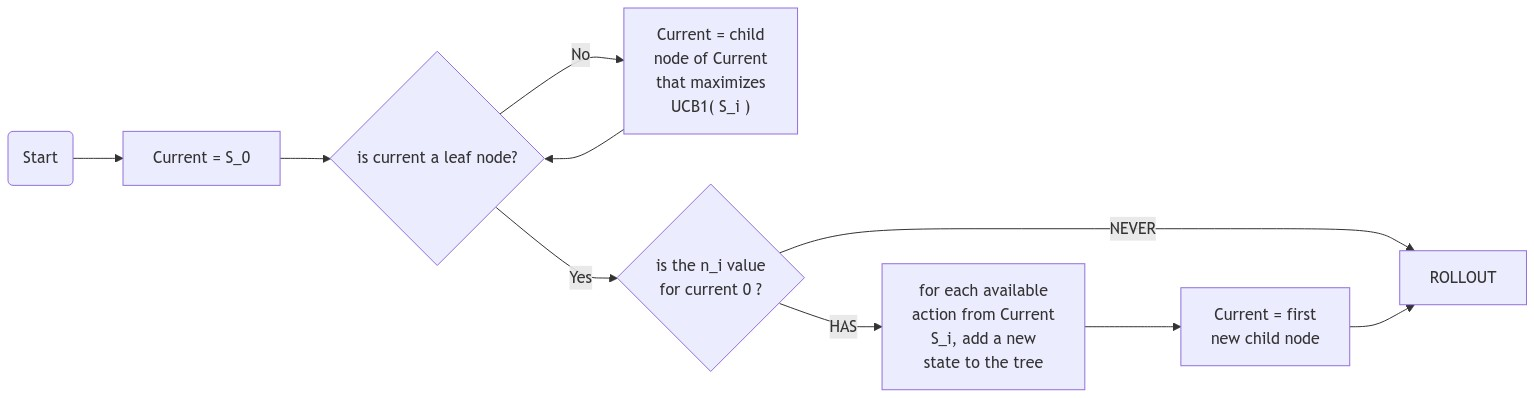

In [ ]:
#@title flow chart
#@markdown step 1, 2 flow chart
mermaid('''flowchart LR
    Start("Start") --> CurrentS0["Current = S_0 "]
    CurrentS0 --> IsCurrentALeafNode{"is current a leaf node?"}
    IsCurrentALeafNode --> |No| AssignCurrentChildNode["Current = child<br/>node of Current<br/>that maximizes<br/> UCB1(  S_i  ) "]
    AssignCurrentChildNode --> IsCurrentALeafNode
    IsCurrentALeafNode --> |Yes| IsTheValueForCurrent0{"is the n_i value<br/>for current 0 ?"}
    IsTheValueForCurrent0 --> |NEVER| Rollout["ROLLOUT"]
    IsTheValueForCurrent0 --> |HAS| ExpandTheTree["for each available <br/> action from Current <br/> S_i, add a new<br/>state to the tree"]
    ExpandTheTree --> AssignCurrentNode["Current = first<br/>new child node"]
    AssignCurrentNode --> Rollout''')

start with $S_0$ as the initial state being the current state

is current a leaf node?

 - **NO**
   - going to explore by calculating the ucb1 value of each of the states, choose the one that maximizes that value
   - calculate $UCB1(...)$ for each of the child states $S_i$ and then you select the node that maximizes that formula
   - keep doing this and going around until you get to a leaf node in the tree
 - **YES**
   - how many times has it been sampled ?
   - **NEVER** been sampled
     - simply do a rollout from there
   - **HAS** been sampled before
     - this is where you add new nodes into the tree
     - for each available action from the current state you add a new state to the tree and then you let current be the first of those new child nodes
     - rollout

Rollout Process $S_i$
  - loop forever
    - if $S_i$ is a terminal state
      - return $value(S_i)$
    - $A_i = random( available\ actions ( S_i ) ) $
    - $S_i = Simulate ( A_i, S_i ) $



iteration 1
rollout(S[1]) ~ 20.0
back_propagate: S[1]
back_propagate: S[0]


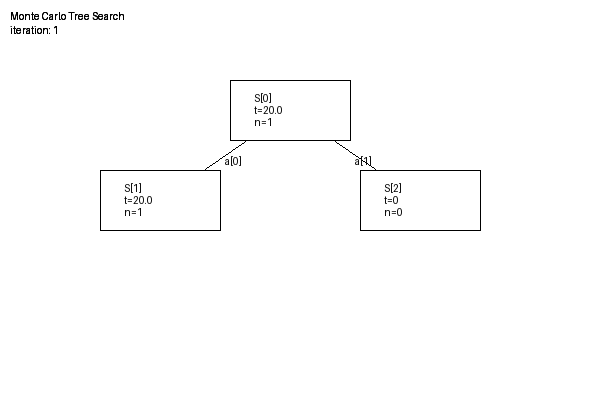

iteration 2
rollout(S[2]) ~ 10.0
back_propagate: S[2]
back_propagate: S[0]


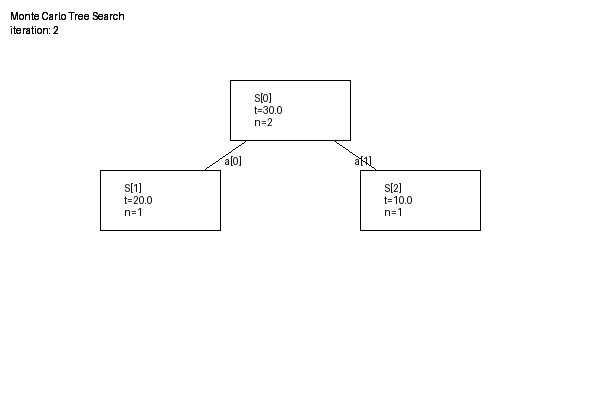

iteration 3
rollout(S[3]) ~ 0.0
back_propagate: S[3]
back_propagate: S[1]
back_propagate: S[0]


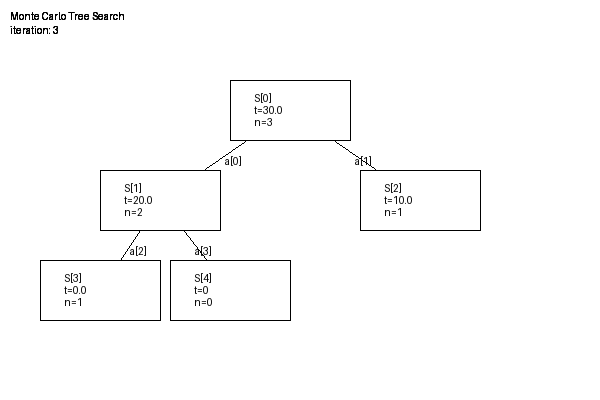

iteration 4
rollout(S[5]) ~ 14.0
back_propagate: S[5]
back_propagate: S[2]
back_propagate: S[0]


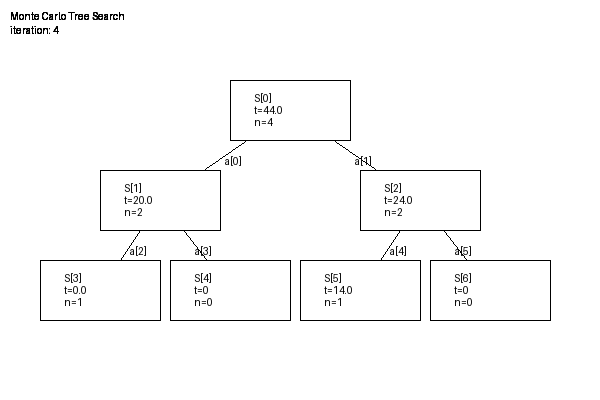

{
  "id": 133010574946272,
  "state_id": 2,
  "value": 10.0,
  "t": 24.0,
  "n": 2
}


In [ ]:
#@title MCTS implementation
import json
import math
import random

from PIL import Image, ImageDraw
from IPython.display import display

# positions for the binary tree nodes
positions = {
    0: (190,  80),
    1: ( 60, 170),
    2: (320, 170),
    3: (  0, 260),
    4: (130, 260),
    5: (260, 260),
    6: (390, 260)
}

# values for each rollout
values = {
    1: 20.,
    2: 10.,
    3: 0.,
    5: 14.,
}

class Action:
    def __init__(self):
        pass

def argmax(x):
    return max(range(len(x)), key=lambda i: x[i])

class MonteCarloTreeState:
    n_state = 0
    def __init__(self, C=2):
        # define state_id, and self-increment
        self.state_id = MonteCarloTreeState.n_state
        MonteCarloTreeState.n_state += 1

        self.t = 0 # total score
        self.n = 0 # number of visits
        self.C = C # exploration parameter

        self._value = None # temp value
        self.parent = None # parent state
        self.children = [] # children states
        self.actions = [Action(), Action()] # actions, expand_nodes

    def back_propagate(self, value):
        # handle itself and everything upward
        current_mct_state = self
        while current_mct_state != None:
            current_mct_state.t += value
            current_mct_state.n += 1 # number of visits + 1
            print(f"back_propagate: S[{current_mct_state.state_id}]")
            current_mct_state = current_mct_state.parent

    def is_leaf_node(self):
        return len(self.children) == 0

    def rollout(self):
        # the rollout is complex in the video
        # however, this implementation align to whiteboard demo
        # simply pick value from "values"
        if self.state_id in values:
            self._value = values[self.state_id]
        else:
            self._value = random.randint(5, 10)
        print(f"rollout(S[{self.state_id}]) ~ {self._value}")
        return self._value

    def get_s0(self):
        state = self
        while state.parent != None:
            state = state.parent
        return state

    def ubc1(self):
        if self.n == 0:
            return float('inf')
        else:
            N = self.get_s0().n # the total sample times comes from s0.n
            # UCB1(S_i) = \bar{V_i} + C \cdot \sqrt{\frac{ln{N}}{n_i}}
            # \bar{V_i}
            exploitation_term = float(self.t) / float(self.n)
            # C \cdot \sqrt{\frac{ln{N}}{n_i}}
            exploration_term = math.sqrt(math.log(float(N)) / float(self.n))
        return exploitation_term + self.C * exploration_term

    def __repl__(self):
        return json.dumps({
            "id": id(self),
            "state_id": self.state_id,
            "value": self._value,
            "t": self.t,
            "n": self.n
        }, indent=2)

    def __str__(self):
        return self.__repl__()

class MonteCarloTreeSearch:
    def __init__(self):
        self.s0 = None # start state
        self.current = None # traverse postion

        # used for visualization
        self._image = None
        self._a_id = 0
        self.iteration = 0

    def expand_nodes(self, mct_state):
        available_actions = mct_state.actions
        for i in range(len(available_actions)):
            state = MonteCarloTreeState()
            state.parent = mct_state # hook parent
            mct_state.children.append(state)

    def search(self):
        self.s0 = MonteCarloTreeState()
        self.current = self.s0
        self.expand_nodes(self.s0)

        for i in range(4):
            self.current = self.s0
            self.iteration = i
            print(f"iteration {self.iteration+1}")
            self.tree_traverse()

            self._image = None
            self.draw_states(self.s0, self.draw_state)
            display(self._image)

        ubc1s = []
        for i in range(len(self.s0.children)):
            ubc1s.append(self.s0.children[i].ubc1())
        # and then you select the node that maximizes that formula
        return self.s0.children[argmax(ubc1s)]

    def tree_traverse(self):
        # The author just illustrate it as a true-or-false
        # however, it should have multiple level down the state tree

        # is current a leaf node?
        while not self.current.is_leaf_node():
            # going to explore by calculating the ucb1 value of each of the states,
            # choose the one that maximizes that value
            # calculate  𝑈𝐶𝐵1(...) for each of the child states 𝑆𝑖
            ubc1s = []
            for i in range(len(self.current.children)):
                ubc1s.append(self.current.children[i].ubc1())
            # and then you select the node that maximizes that formula
            self.current = self.current.children[argmax(ubc1s)]

        if self.current.is_leaf_node():
            # is the n_i value for current 0 ?
            #if self.current.n == 0:
            #    # never been sampled
            #    pass
            if self.current.n != 0:
                # has been sampled before
                self.expand_nodes(self.current)
                self.current = self.current.children[0]
            self.current.rollout()
            self.current.back_propagate(self.current._value)

    def draw_states(self, state, draw_state_func):
        draw_state_func(state)
        for i in range(len(state.children)):
            self.draw_states(state.children[i], draw_state_func)

    def draw_state(self, state):
        black, white = (0,0,0), (255,255,255)
        canvas_width, canvas_height = 600, 400
        box_width, box_height = 120, 60
        x_offset, y_offset = 40, 0

        if self._image == None:
            self._image = Image.new("RGB", (canvas_width, canvas_height), white)
            self._a_id = 0 # reset the action id

        state_id = state.state_id

        draw = ImageDraw.Draw(self._image)
        draw.text((10,10), f"Monte Carlo Tree Search", fill=black)
        draw.text((10,24), f"iteration: {self.iteration+1}", fill=black)
        x0, y0 = positions[state_id]
        x0 += x_offset

        if len(state.children) >0:
            cx0, cy0 = positions[state_id]
            cx0 += x_offset
            cx0 += box_width // 2
            cy0 += box_height // 2
            for i in range(len(state.children)):
                cx1, cy1 = positions[state.children[i].state_id]
                cx1 += x_offset
                cx1 += box_width // 2
                cy1 += box_height // 2
                draw.line((cx0,cy0, cx1, cy1), fill=black)
                draw.text(xy=((cx0+cx1)//2, (cy0+cy1)//2), fill=black, text=f"a[{self._a_id}]")
                self._a_id += 1

        draw.rectangle((x0, y0, x0+box_width, y0+box_height),fill=white, outline=black)
        draw.text(xy=(x0+24, y0+12), fill=black, text=f"S[{state.state_id}]")
        draw.text(xy=(x0+24, y0+24), fill=black, text=f"t={state.t}")
        draw.text(xy=(x0+24, y0+36), fill=black, text=f"n={state.n}")

print(MonteCarloTreeSearch().search())


https://ai-boson.github.io/mcts/

In [1]:
import json
import math
import random
import copy

class Action:
    def __init__(self, row, col, player):
        self.row = row
        self.col = col
        self.player = player

    def apply(self, game_state):
        # Place the player's mark on the specified cell
        new_state = copy.deepcopy(game_state)
        new_state[self.row][self.col] = self.player
        return new_state

    def __str__(self):
        return f"Action({self.row}, {self.col})"

def argmax(x):
    return max(range(len(x)), key=lambda i: x[i])

def argmin(x):
    return min(range(len(x)), key=lambda i: x[i])

class MonteCarloTreeState:
    n_state = 0

    def __init__(self, game_state=None, current_player=1, C=2):
        self.state_id = MonteCarloTreeState.n_state
        MonteCarloTreeState.n_state += 1
        self.t = 0
        self.n = 0
        self.C = C
        self._value = None
        self.parent = None
        self.children = []
        self.game_state = game_state if game_state else self.initialize_game()
        self.current_player = current_player

    def switch_player(self):
        # Switch the current player between 'X' and 'O'
        self.current_player *= -1

    def initialize_game(self):
        # Initialize an empty Tic-Tac-Toe board (3x3 grid)
        return [[0 for _ in range(3)] for _ in range(3)]

    def back_propagate(self, value):
        # Backpropagate the rollout result through the tree
        current_mct_state = self
        while current_mct_state is not None:
            current_mct_state.t += value
            current_mct_state.n += 1  # Increase the visit count
            current_mct_state = current_mct_state.parent

    def is_leaf_node(self):
        return len(self.children) == 0

    def rollout(self):
        # Simulate a random game from the current state
        current_game_state = copy.deepcopy(self.game_state)
        current_player = self.current_player

        while True:
            # Check if the game is over
            game_over, winner = self.is_game_over(current_game_state)
            if game_over:
                if winner == 1:
                    self._value = 1  # X wins
                elif winner == -1:
                    self._value = -1  # O wins
                else:
                    self._value = 0  # Draw
                return self._value

            # Randomly select an available action
            actions = self.get_available_actions(current_game_state)
            if actions:
                action = random.choice(actions)
                current_game_state = action.apply(current_game_state)
                current_player *= -1

    def get_available_actions(self, game_state=None):
        # Return a list of available moves (empty cells)
        actions = []
        game_state = game_state if game_state else self.game_state
        for row in range(3):
            for col in range(3):
                if game_state[row][col] == 0:
                    actions.append(Action(row, col, self.current_player))
        return actions

    def is_game_over(self, game_state):
        # Check rows, columns, and diagonals for a win
        for row in game_state:
            if abs(sum(row)) == 3:
                return True, self.current_player
        for col in range(3):
            if abs(sum(game_state[row][col] for row in range(3))) == 3:
                return True, self.current_player
        if abs(game_state[0][0] + game_state[1][1] + game_state[2][2]) == 3 or \
           abs(game_state[0][2] + game_state[1][1] + game_state[2][0]) == 3:
            return True, self.current_player

        # Check for draw
        if all(cell != 0 for row in game_state for cell in row):
            return True, 0  # Draw
        return False, None  # Game not over

    def get_s0(self):
        state = self
        while state.parent != None:
            state = state.parent
        return state

    def ubc1(self, C=2.0):
        if self.n == 0:
            return float('inf')
        else:
            N = self.get_s0().n
            exploitation_term = float(self.t) / float(self.n)
            exploration_term = math.sqrt(math.log(float(N)) / float(self.n))
        return exploitation_term + C * exploration_term

    def __repl__(self):
        return json.dumps({
            "id": id(self),
            "state_id": self.state_id,
            "value": self._value,
            "t": self.t,
            "n": self.n
        }, indent=2)

    def __str__(self):
        return self.__repl__()

    def visualize(self):
        lines = ["", "", ""]
        for i in range(len(self.game_state)):
            for j in range(len(self.game_state[i])):
                v = " "
                if self.game_state[i][j] == 1:
                    v = "X"
                elif self.game_state[i][j] == -1:
                    v = "O"
                lines[i] += v
        lines = [
            "┌───┬───┬───┐",
            "│ "+lines[0][0]+" │ "+lines[0][1]+" │ "+lines[0][2]+" │",
            "├───┼───┼───┤",
            "│ "+lines[1][0]+" │ "+lines[1][1]+" │ "+lines[1][2]+" │",
            "├───┼───┼───┤",
            "│ "+lines[2][0]+" │ "+lines[2][1]+" │ "+lines[2][2]+" │",
            "└───┴───┴───┘",
        ]
        return "\n".join(lines)

class MonteCarloTreeSearch:
    def __init__(self):
        self.s0 = None

    def expand_nodes(self, mct_state):
        available_actions = mct_state.get_available_actions()
        for action in available_actions:
            new_game_state = action.apply(mct_state.game_state)
            new_state = MonteCarloTreeState(game_state=new_game_state, current_player=mct_state.current_player)
            new_state.switch_player()
            new_state.parent = mct_state
            mct_state.children.append(new_state)

    def search(self, s0=None):
        iterations = 10000
        self.s0 = s0 if s0 else MonteCarloTreeState()
        self.expand_nodes(self.s0)

        for _ in range(iterations):
            self.current = self.s0
            self.tree_traverse()

        ubc1s = [child.ubc1(0.) for child in self.s0.children]
        return self.s0.children[argmax(ubc1s)]

    def tree_traverse(self):
        while not self.current.is_leaf_node():
            ubc1s = [child.ubc1(child.C) for child in self.current.children]
            self.current = self.current.children[argmax(ubc1s)]

        if self.current.is_leaf_node():
            if self.current.n != 0:
                self.expand_nodes(self.current)
                if len(self.current.children)>0:
                    self.current = self.current.children[0]
            self.current.rollout()
            self.current.back_propagate(self.current._value)

def repl():

    def input_coord():
        x, y = map(int, input("Input x, y (1-based): ").split(","))
        return x,y

    game_state = [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ]
    current_player = 1

    gs = MonteCarloTreeState(game_state=game_state, current_player=current_player)
    print("Tic-Tac-Toe game starts!")
    print("You go first")
    print(gs.visualize())

    while True:
        while True:
            x, y = input_coord()
            if game_state[y-1][x-1] == 0:
                break
            print(f"Cannot place X at: {x},{y}")
        game_state[y-1][x-1] = current_player
        current_player *= -1

        print("Perform Monte Carlo Tree Search")
        gs = MonteCarloTreeState(game_state=game_state, current_player=current_player)
        is_game_over, player = gs.is_game_over(gs.game_state)
        if is_game_over:
            if player:
                print(f"player X win!")
            else:
                print("draw game!")
            print(gs.visualize())
            break

        next_gs = MonteCarloTreeSearch().search(gs)

        print(next_gs.visualize())
        game_state = copy.deepcopy(next_gs.game_state)

        is_game_over, player = next_gs.is_game_over(next_gs.game_state)
        if is_game_over:
            if player:
                print(f"player O win!")
            else:
                print("draw game!")
            print(next_gs.visualize())
            break
        current_player *= -1

repl()


Tic-Tac-Toe game starts!
You go first
┌───┬───┬───┐
│   │   │   │
├───┼───┼───┤
│   │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
Input x, y (1-based): 1,1
Perform Monte Carlo Tree Search
┌───┬───┬───┐
│ X │ O │   │
├───┼───┼───┤
│   │   │   │
├───┼───┼───┤
│   │   │   │
└───┴───┴───┘
Input x, y (1-based): 2,2
Perform Monte Carlo Tree Search
┌───┬───┬───┐
│ X │ O │   │
├───┼───┼───┤
│   │ X │   │
├───┼───┼───┤
│   │   │ O │
└───┴───┴───┘
Input x, y (1-based): 1,3
Perform Monte Carlo Tree Search
┌───┬───┬───┐
│ X │ O │ O │
├───┼───┼───┤
│   │ X │   │
├───┼───┼───┤
│ X │   │ O │
└───┴───┴───┘
Input x, y (1-based): 1,2
Perform Monte Carlo Tree Search
player X win!
┌───┬───┬───┐
│ X │ O │ O │
├───┼───┼───┤
│ X │ X │   │
├───┼───┼───┤
│ X │   │ O │
└───┴───┴───┘
